# DETECTION OF RECOLORED IMAGES USING  DEEP DISCRIMINATIVE MODEL

## Training The Model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#scikit-learn and keras for training and testing the model 
import matplotlib.pyplot as plt # visualizing the model
import random
import os
print(os.listdir("dataset"))

Using TensorFlow backend.


['originalimg', 'recolorimg', 'source', 'target', 'testingset', 'trainingset']


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

> - Use the dataset created by RecImDet.ipnyb for training the model

In [3]:
#we use supervised learning
filenames = os.listdir("dataset/trainingset")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'pic':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

,filename,category
0,img.0.jpg,0
1,img.1.jpg,0
2,img.10.jpg,0
3,img.11.jpg,0
4,img.12.jpg,0


In [5]:
df.tail()

,filename,category
95,pic.5.jpg,1
96,pic.6.jpg,1
97,pic.7.jpg,1
98,pic.8.jpg,1
99,pic.9.jpg,1


In [6]:
df['category']=df['category'].astype(str)

In [7]:
df.dtypes

filename    object
category    object
dtype: object

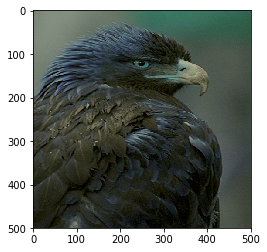

In [8]:
sample = random.choice(filenames)
image = load_img("dataset/trainingset/"+sample)
plt.imshow(image)

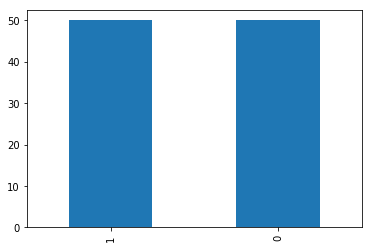

In [9]:
df['category'].value_counts().plot.bar()

##### Model Architecture
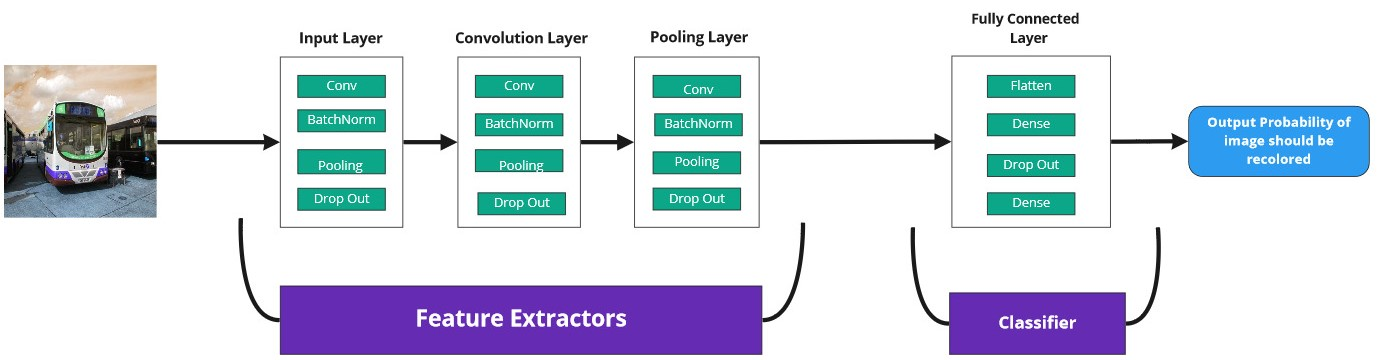
- **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
- **Convolution Layer**: This layer will extract features from image.
- **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
- **Fully Connected Layer**: It connect the network from a layer to another layer
- **Output Layer**: It is the predicted values layer.

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

**Callbacks**

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

> **Early Stop**
   - To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [12]:
earlystop = EarlyStopping(monitor='val_loss',patience=10)

> **Learning Rate Reduction**
- We will reduce the learning rate when then accuracy not increase for 2 steps

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.05, 
                                            min_lr=0.00001)

In [14]:
callbacks = [earlystop,learning_rate_reduction]

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [16]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=4

In [17]:
print(train_df.shape)
print(validate_df.shape)

(80, 2)
(20, 2)


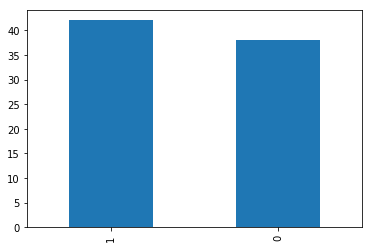

In [18]:
train_df['category'].value_counts().plot.bar()

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [20]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "dataset/trainingset", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 80 validated image filenames belonging to 2 classes.


In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "dataset/trainingset", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 20 validated image filenames belonging to 2 classes.


**Fit the model**

In [22]:
epochs=3 if FAST_RUN else 20
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    
)

Epoch 1/20
20/20 [==============================] - 18s 883ms/step - loss: 1.1188 - accuracy: 0.4375 - val_loss: 0.8124 - val_accuracy: 0.5000
Epoch 2/20
20/20 [==============================] - 10s 505ms/step - loss: 0.6670 - accuracy: 0.6375 - val_loss: 1.4606 - val_accuracy: 0.6000
Epoch 3/20
20/20 [==============================] - 9s 445ms/step - loss: 0.9412 - accuracy: 0.5000 - val_loss: 2.7328 - val_accuracy: 0.6000
Epoch 4/20
20/20 [==============================] - 8s 424ms/step - loss: 0.9935 - accuracy: 0.4625 - val_loss: 0.1348 - val_accuracy: 0.6000
Epoch 5/20
20/20 [==============================] - 10s 497ms/step - loss: 0.7332 - accuracy: 0.6250 - val_loss: 1.4321 - val_accuracy: 0.6000
Epoch 6/20
20/20 [==============================] - 9s 442ms/step - loss: 0.8036 - accuracy: 0.6125 - val_loss: 0.0279 - val_accuracy: 0.6000
Epoch 7/20
20/20 [==============================] - 9s 472ms/step - loss: 0.8669 - accuracy: 0.5750 - val_loss: 2.5890 - val_accuracy: 0.6000
Epo

In [23]:
trainmodel=model.predict_generator(train_generator, steps=np.ceil(train_df.shape[0]/batch_size))
trainmean=sum(trainmodel)/len(trainmodel)
trainpred=trainmean[0]
trainpred

0.30049127

**Save the model**

In [24]:
model.save_weights("RecImgDecNet.h5")

**Visualize Training**

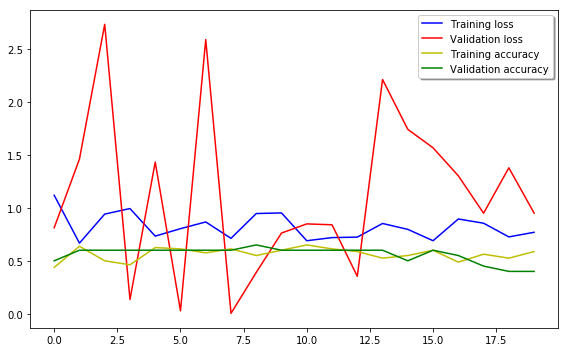

In [25]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 5))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.plot(history.history['accuracy'], color='y', label="Training accuracy")
ax1.plot(history.history['val_accuracy'], color='g',label="Validation accuracy")


#ax1.set_xticks(np.arange(1, epochs, 1))
#ax1.set_yticks(np.arange(0, 1, 0.1))
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Testing The Model

**Preparing Test Data**

In [26]:
test_filenames = os.listdir("dataset/testingset")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [27]:
print(nb_samples)

32


**Creating Test Generator**

In [28]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "dataset/testingset", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 32 validated image filenames.


**Predict**
 

- For categoral classication the prediction will come with probability of each category.

In [29]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [30]:
print(predict)

[[0.49242362]
 [0.60176605]
 [0.09489156]
 [0.05363239]
 [0.38154963]
 [0.10217618]
 [0.12913752]
 [0.39264187]
 [0.09398732]
 [0.07268691]
 [0.10136836]
 [0.17030558]
 [0.07694412]
 [0.584978  ]
 [0.1659023 ]
 [0.01312191]
 [0.39969027]
 [0.12394919]
 [0.1755235 ]
 [0.5383466 ]
 [0.36138198]
 [0.07850992]
 [0.13300972]
 [0.47959194]
 [0.12791209]
 [0.5198955 ]
 [0.43640354]
 [0.54227483]
 [0.72146964]
 [0.29969528]
 [0.32250142]
 [0.42870083]]


In [31]:
threshold = trainpred
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

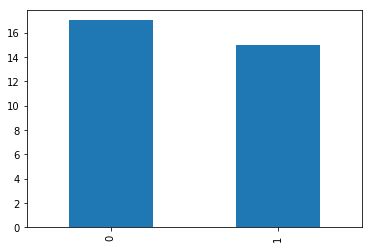

In [32]:
test_df['category'].value_counts().plot.bar()

**Visualize the Test Results**

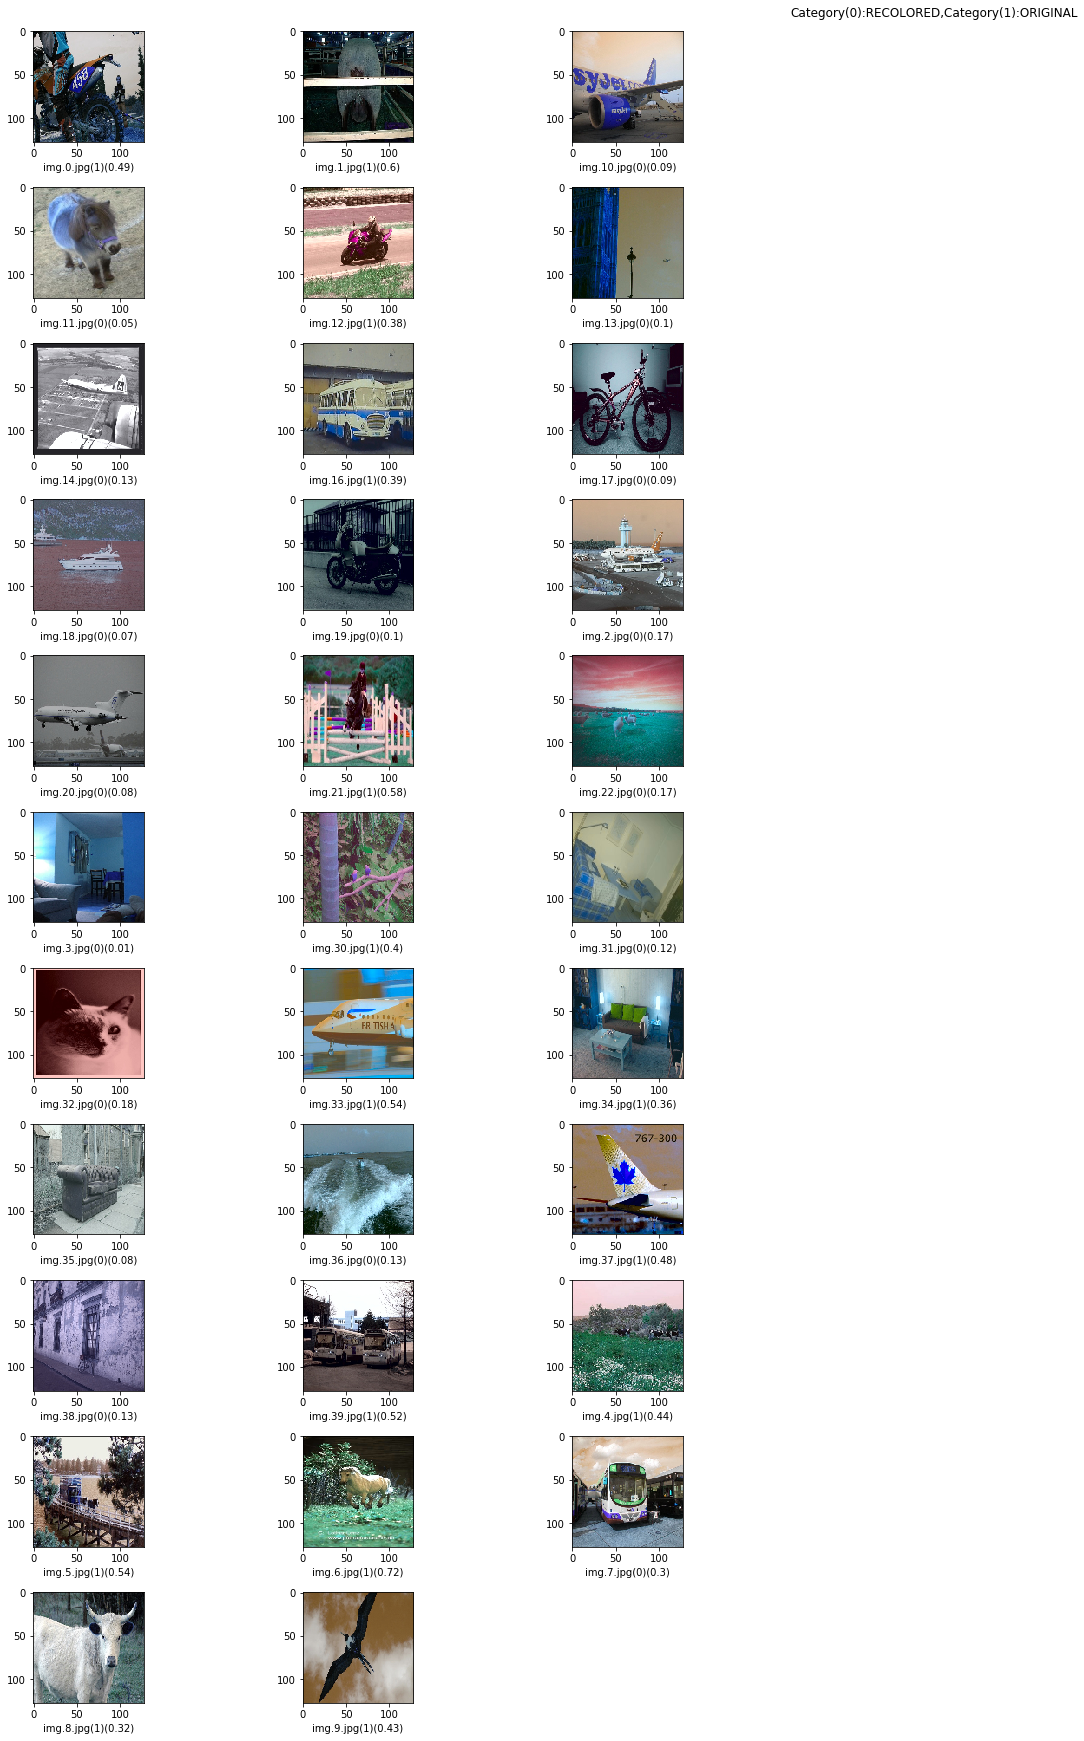

In [33]:
sample_test = test_df #.head(5)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability']
    img = load_img("dataset/testingset/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(11, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.figtext(1,1,'Category(0):RECOLORED,Category(1):ORIGINAL',fontsize='large')    
plt.tight_layout()
plt.show()


**Submission of Test Results to a CSV**

In [34]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

In [35]:
print('\n \n Category(0):RECOLORED,Category(1):ORIGINAL \n \n')
print(test_df)


 
 Category(0):RECOLORED,Category(1):ORIGINAL 
 

      filename  probability  category
0    img.0.jpg     0.492424         1
1    img.1.jpg     0.601766         1
2   img.10.jpg     0.094892         0
3   img.11.jpg     0.053632         0
4   img.12.jpg     0.381550         1
5   img.13.jpg     0.102176         0
6   img.14.jpg     0.129138         0
7   img.16.jpg     0.392642         1
8   img.17.jpg     0.093987         0
9   img.18.jpg     0.072687         0
10  img.19.jpg     0.101368         0
11   img.2.jpg     0.170306         0
12  img.20.jpg     0.076944         0
13  img.21.jpg     0.584978         1
14  img.22.jpg     0.165902         0
15   img.3.jpg     0.013122         0
16  img.30.jpg     0.399690         1
17  img.31.jpg     0.123949         0
18  img.32.jpg     0.175524         0
19  img.33.jpg     0.538347         1
20  img.34.jpg     0.361382         1
21  img.35.jpg     0.078510         0
22  img.36.jpg     0.133010         0
23  img.37.jpg     0.479592         1